# Libraries
All libraries used in the notebook

In [1]:
# https://docs.python.org/3/library/itertools.html

import itertools
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Viz
import matplotlib.pyplot as plt
import seaborn as sn

# Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tdata

In [2]:
# setting a random seed. with this we have our results absolutely identical
random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)



## CPU/GPU
Cuda: Library to use GPUs.


cudnn: Library to do Neural Net stuff on GPUs (probably uses Cuda to talk to the GPUs)

In [3]:
# CPU 
torch.backends.cudnn.enabled = False

## Interview introduction

The objective is to build a classifier on MNIST dataset that meets certain performance criteria.
For this task, you will need to train the model of your choice and compute the following metrics:
* Per class FPR
* Per class TPR

The goal for your classifier is to reduce the false positive rate as low as possible for each class in the test set while maintaining the recall as high as possible.

You will find below the current (naive) training pipeline for this task. We suggest you spend some time looking at the current existing code and existing classes.
We suggest focusing on improvements that do not fundamentally change the overall code structure first as this would make it easier to debug and fit in the time given.

You are free to ask any questions including part of the code you may not understand.

**Important Note**: All markdown sections and comments below are written from the perspective of a junior employee. It simply explains what is being done but trust its logic with caution. The code should not contain hidden bugs. We have also written a few hints in *italic* to help guide the interview, we still suggest you get an overview of the whole work before trying to modify it.

# Download dataset and create data loaders

In [4]:
# As a separate task for learning purposes later I'll create a custom implementations of torch.utils.data.DataLoader and torchvision.datasets.MNIST

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

2.8%

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

98.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Dataset Exploration
Let's first observe the dataset. The dataset class will also be used to generate batches and feed the model.

*Interview: Is exploration sufficient ? Can the dataset class be improved ?*

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([256, 1, 28, 28])

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [8]:
example_data.shape

torch.Size([1000, 1, 28, 28])

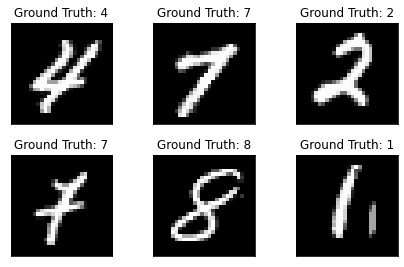

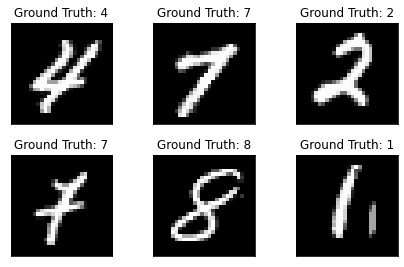

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Model
Since we use image data we use a CNN with the usual Conv + Relu + maxpooling.

*Interview: How can we achieve better performances ?*

In [10]:
class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(nn.Conv2d(1, 10, 3),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),
                                  nn.Conv2d(10, 20, 3),
                                  nn.ReLU(),
                                  nn.AdaptiveAvgPool2d(1))
        self.lin = nn.Linear(20, 10)
        
    def forward(self, x):
        h = self.main(x)
        logits = self.lin(h.squeeze(2).squeeze(2))
        return logits 

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
model = MNISTClassifier().to(device)

In [13]:
#model(torch.rand((1, 1, 28, 28)).to(device))

# Training loop
The model is trained until its loss starts to stagnate. After a few trials, 5 epochs looks like a good time to stop according to the train plot.

*Interview: Are we doing best practices ?*

In [14]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

In [15]:
losses = []
for e in range(2):
    print(e)
    for x, y in train_loader:
        opt.zero_grad()
        y = y.to(device)
        logits = model(x.to(device))
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        losses.append(loss.item())

0
1


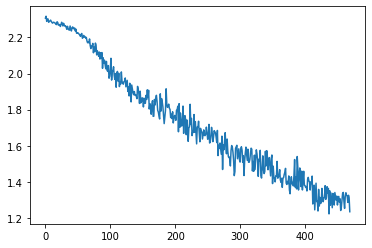

In [16]:
plt.plot(losses)

# Performance on test data
Here we display the resulting accuracy and and confusion matrix plot.

*Interview: Think about ways to look at results that are both informative and could help us for future model versions*

In [17]:
test_labels = []
preds = []

with torch.no_grad():
    for x, y in test_loader:
        logits = model(x.to(device))
        predicted_labels = logits.argmax(1).cpu().detach().numpy()
        preds.append(predicted_labels)
        test_labels.append(y)


preds = np.concatenate(preds, axis=0)
labels = np.concatenate(test_labels, axis=0)

In [17]:
accuracy_score(labels, preds)

0.5993

In [18]:
def generate_matplotlib_cm(cm, name_dict):
    fig = plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(cm, cmap='Oranges')

    classes = list(name_dict.values())
    tick_marks = np.arange(len(classes))

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, fontsize=10, rotation=-90,  ha='center')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True Label', fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=10, va='center')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd') if cm[i, j] != 0 else '.', horizontalalignment="center", fontsize=9,
                verticalalignment='center', color="black")
    plt.show()

In [19]:
name_dict = {}
for index in range(10):
  name_dict[index] = str(index)

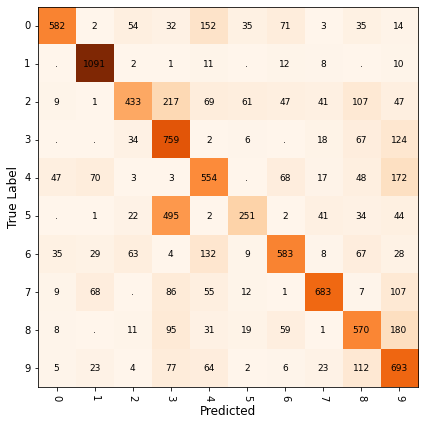

In [20]:
generate_matplotlib_cm(confusion_matrix(labels, preds), name_dict)

## Here you need to write code for displaying the FPR and TPR for each class in test

In [21]:
def calculate_metrix(labels, preds):
  matrix = confusion_matrix(labels, preds)

  # Positive (P)
  positive = np.sum(matrix, axis=1)
  print("positive", positive)

  # Negative (N)
  negative = np.sum(matrix) - np.sum(matrix, axis=1)
  print("negative", negative)

  print('--')

  # True Positive (TP)
  tp = np.diagonal(matrix)
  print("tp",  tp)

  # True Positive Rate (TPR)
  tpr = tp / positive
  print("tpr",  tpr)

  print('--')

  # False Positive (FP)
  fp = np.sum(matrix, axis=0) - tp
  print("fp", fp)

  # False Positive Rate (FPR)
  fpr = fp / negative
  print("fpr", fpr)

  print('--')

  # False Negative (FN)
  fn = np.sum(matrix, axis=1) - tp
  print("fn",  fn)

  # True Negative (NT)
  tn = np.sum(matrix) - (fp + fn + tp)
  print("tn",  tn)

  # Accuracy (ACC)
  acc = (tp + tn) / np.sum(matrix)
  print("acc", acc)


calculate_metrix(labels, preds)

positive [ 980 1135 1032 1010  982  892  958 1028  974 1009]
negative [9020 8865 8968 8990 9018 9108 9042 8972 9026 8991]
--
tp [ 582 1091  433  759  554  251  583  683  570  693]
tpr [0.59387755 0.96123348 0.41957364 0.75148515 0.56415479 0.28139013
 0.6085595  0.66439689 0.58521561 0.68681863]
--
fp [ 113  194  193 1010  518  144  266  160  477  726]
fpr [0.01252772 0.02188381 0.02152096 0.11234705 0.05744067 0.01581028
 0.02941827 0.01783326 0.05284733 0.08074741]
--
fn [398  44 599 251 428 641 375 345 404 316]
tn [8907 8671 8775 7980 8500 8964 8776 8812 8549 8265]
acc [0.9489 0.9762 0.9208 0.8739 0.9054 0.9215 0.9359 0.9495 0.9119 0.8958]


## Interview: Is exploration sufficient ? Can the dataset class be improved ?

Answer: not, sufficient. 
1. We don't even know how many samples do we have in train set
2. We don't know about whther it's balanced or inbalanced

Answer: 1. We don't even know how many samples do we have in train set

In [22]:
print(train_loader.dataset)
print(test_loader.dataset)
print(len(train_loader.dataset))
print(len(test_loader.dataset))



Dataset MNIST
    Number of datapoints: 60000
    Root location: /files/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /files/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
60000
10000


## Checking the Dataset

In [23]:
datasets = [train_loader.dataset, test_loader.dataset]

labels_count = 10
labels = [*range(labels_count)]
values = []

for index, ds in enumerate(datasets):
  t = ds.targets
  avarage = ds.targets.shape[0] / labels_count
  values.append([])


  for label in range(labels_count):

      amount = int(t[t == label].shape[0])
      # amount -= avarage
      values[index].append(amount)

print(labels)
print(values)




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949], [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]]


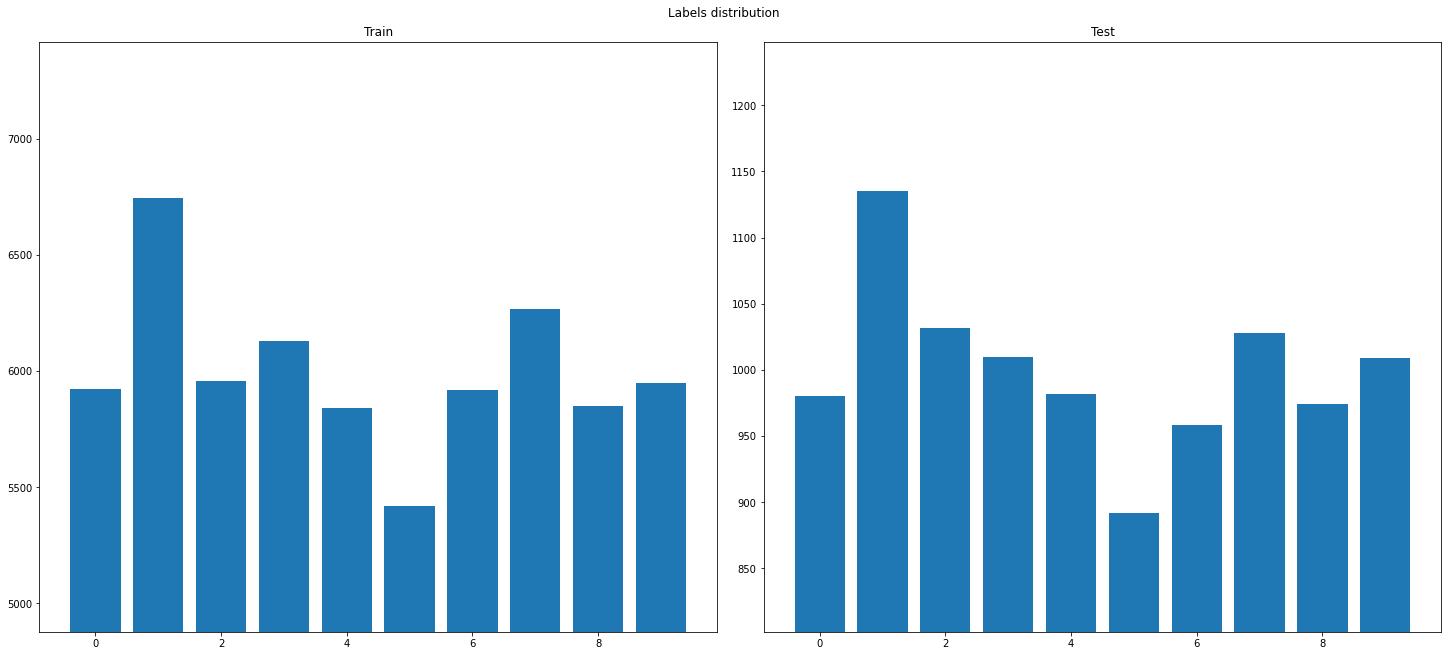

In [24]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(20,9))

for index, ds in enumerate(datasets):
  title = "Train" if index == 0 else "Test"
  axs[index].set_title(title)
  axs[index].set(ylim=[int(min(values[index]) * 0.9), int(max(values[index]) * 1.1)])
  axs[index].bar(labels, values[index])
  

plt.suptitle('Labels distribution')
plt.show()



Our Dataset is a bit imbalanced but not that much

## We can do the data augmentation

In [34]:
train_loader_rotated = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                              torchvision.transforms.RandomRotation(15),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=256, shuffle=True)

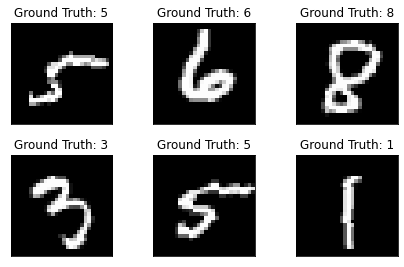

In [35]:
examples = enumerate(train_loader_rotated)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
# fig

In [36]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [37]:

train_loader_gaussian_noise = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               AddGaussianNoise(0.1, 0.08),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=256, shuffle=True)

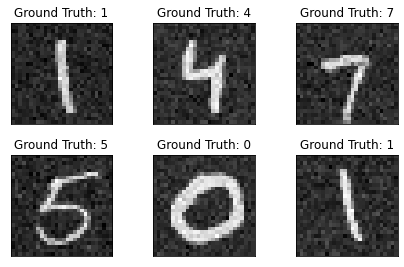

In [38]:
examples = enumerate(train_loader_gaussian_noise)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [39]:
train_dataset_combined = torch.utils.data.ConcatDataset([train_loader.dataset, train_loader_rotated.dataset, train_loader_gaussian_noise.dataset])
train_loader =  torch.utils.data.DataLoader(train_dataset_combined, batch_size=256, shuffle=True)

0
1
0.8625


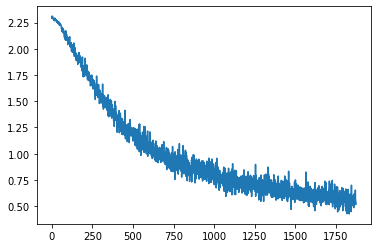

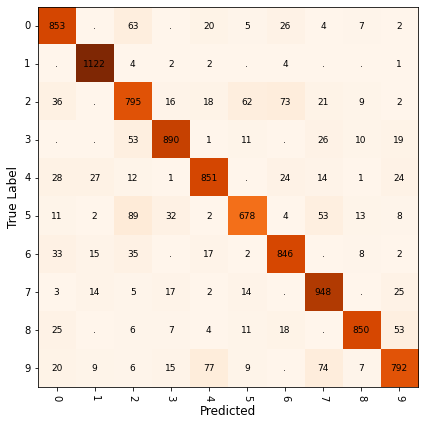

positive [ 980 1135 1032 1010  982  892  958 1028  974 1009]
negative [9020 8865 8968 8990 9018 9108 9042 8972 9026 8991]
--
tp [ 853 1122  795  890  851  678  846  948  850  792]
tpr [0.87040816 0.98854626 0.77034884 0.88118812 0.86659878 0.76008969
 0.88308977 0.92217899 0.87268994 0.78493558]
--
fp [156  67 273  90 143 114 149 192  55 136]
fpr [0.0172949  0.00755781 0.03044157 0.01001112 0.01585717 0.01251647
 0.01647866 0.02139991 0.00609351 0.01512624]
--
fn [127  13 237 120 131 214 112  80 124 217]
tn [8864 8798 8695 8900 8875 8994 8893 8780 8971 8855]
acc [0.9717 0.992  0.949  0.979  0.9726 0.9672 0.9739 0.9728 0.9821 0.9647]


In [40]:
model = MNISTClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
losses = []
for e in range(2):
    print(e)
    for x, y in train_loader:
        opt.zero_grad()
        y = y.to(device)
        logits = model(x.to(device))
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        losses.append(loss.item())

plt.plot(losses)        


test_labels = []
preds = []

with torch.no_grad():
    for x, y in test_loader:
        logits = model(x.to(device))
        predicted_labels = logits.argmax(1).cpu().detach().numpy()
        preds.append(predicted_labels)
        test_labels.append(y)


preds = np.concatenate(preds, axis=0)
labels = np.concatenate(test_labels, axis=0)

print(accuracy_score(labels, preds))

generate_matplotlib_cm(confusion_matrix(labels, preds), name_dict)
calculate_metrix(labels, preds)


Data augmentation works

## We can have a more complicated model


In [41]:
class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(nn.Conv2d(1, 10, 3),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),
                                  nn.Conv2d(10, 20, 3),
                                  nn.ReLU(),
                                  nn.Conv2d(20, 40, 3),
                                  nn.ReLU(),                                  
                                  nn.AdaptiveAvgPool2d(1))
        self.lin = nn.Linear(40, 10)
        
    def forward(self, x):
        h = self.main(x)
        logits = self.lin(h.squeeze(2).squeeze(2))
        return logits 

Also we will compare metrics from train and test datasets to see whether the model is overtrained 

0
1
Train metrics
positive [47384 53936 47664 49048 46736 43368 47344 50120 46808 47592]
negative [432616 426064 432336 430952 433264 436632 432656 429880 433192 432408]
--
tp [41794 51729 36553 41137 38518 35124 40339 43797 38495 37929]
tpr [0.88202769 0.95908113 0.76688906 0.83870902 0.82416125 0.80990592
 0.85204039 0.87384278 0.82240215 0.79696167]
--
fp [9288 4214 9245 9357 5266 7754 5136 9282 6859 8184]
fpr [0.02146939 0.00989053 0.02138383 0.02171239 0.01215425 0.01775866
 0.01187086 0.02159207 0.01583363 0.01892657]
--
fn [ 5590  2207 11111  7911  8218  8244  7005  6323  8313  9663]
tn [423328 421850 423091 421595 427998 428878 427520 420598 426333 424224]
acc [0.96900417 0.98662292 0.95759167 0.964025   0.97190833 0.96667083
 0.97470625 0.96748958 0.96839167 0.96281875]
Test metrics
0.9451


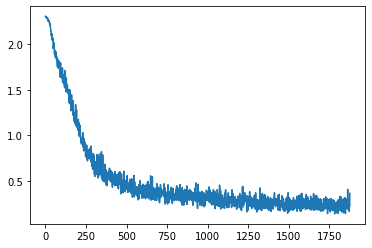

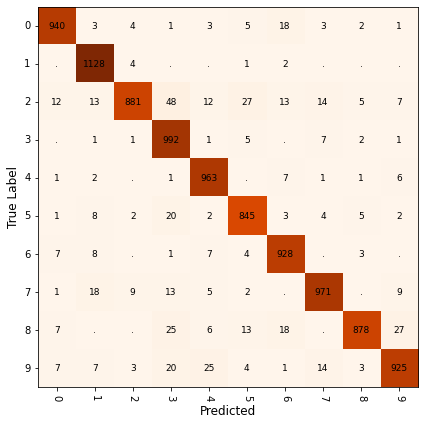

positive [ 980 1135 1032 1010  982  892  958 1028  974 1009]
negative [9020 8865 8968 8990 9018 9108 9042 8972 9026 8991]
--
tp [ 940 1128  881  992  963  845  928  971  878  925]
tpr [0.95918367 0.9938326  0.85368217 0.98217822 0.98065173 0.94730942
 0.96868476 0.94455253 0.90143737 0.91674926]
--
fp [ 36  60  23 129  61  61  62  43  21  53]
fpr [0.00399113 0.00676819 0.00256467 0.01434928 0.00676425 0.00669741
 0.00685689 0.00479269 0.00232661 0.00589478]
--
fn [ 40   7 151  18  19  47  30  57  96  84]
tn [8984 8805 8945 8861 8957 9047 8980 8929 9005 8938]
acc [0.9924 0.9933 0.9826 0.9853 0.992  0.9892 0.9908 0.99   0.9883 0.9863]


In [64]:
model = MNISTClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
losses = []
train_labels = []
train_preds = []
for e in range(2):
    print(e)
    for x, y in train_loader:
        opt.zero_grad()
        y = y.to(device)
        logits = model(x.to(device))
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
        predicted_labels = logits.argmax(1).cpu().detach().numpy()
        train_preds.append( predicted_labels )    
        train_labels.append(y)

plt.plot(losses)


print("Train metrics")
train_preds_  = np.concatenate(train_preds, axis=0)
train_labels_ = np.concatenate(train_labels, axis=0)
calculate_metrix(train_labels_, train_preds_)

test_labels = []
test_preds = []

with torch.no_grad():
    for x, y in test_loader:
        logits = model(x.to(device))
        predicted_labels = logits.argmax(1).cpu().detach().numpy()
        test_preds.append(predicted_labels)
        test_labels.append(y)

print("Test metrics")
test_preds_ = np.concatenate(test_preds, axis=0)
test_labels_ = np.concatenate(test_labels, axis=0)

print(accuracy_score(test_labels_, test_preds_))

generate_matplotlib_cm(confusion_matrix(test_labels_, test_preds_), name_dict)


calculate_metrix(test_labels_, test_preds_)



### We also can try the dropout

In [67]:
class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(nn.Conv2d(1, 10, 3),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),
                                  nn.Dropout(0.2),
                                  nn.Conv2d(10, 20, 3),
                                  nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Conv2d(20, 40, 3),
                                  nn.ReLU(),      
                                  nn.Dropout(0.2),
                                  nn.AdaptiveAvgPool2d(1))
        self.lin = nn.Linear(40, 10)
        
    def forward(self, x):
        h = self.main(x)
        logits = self.lin(h.squeeze(2).squeeze(2))
        return logits     

0
1
Train metrics
positive [47384 53936 47664 49048 46736 43368 47344 50120 46808 47592]
negative [432616 426064 432336 430952 433264 436632 432656 429880 433192 432408]
--
tp [39996 50480 35694 38587 37920 31958 39181 41248 36340 34623]
tpr [0.84408239 0.93592406 0.74886707 0.78671913 0.81136597 0.73690279
 0.82758111 0.82298484 0.77636301 0.72749622]
--
fp [12608  5992 11799  9186  7416  8381  6924 10569 10321 10777]
fpr [0.02914363 0.01406361 0.02729127 0.0213156  0.01711658 0.01919465
 0.01600348 0.02458593 0.02382546 0.02492322]
--
fn [ 7388  3456 11970 10461  8816 11410  8163  8872 10468 12969]
tn [420008 420072 420537 421766 425848 428251 425732 419311 422871 421631]
acc [0.95834167 0.98031667 0.95048125 0.95906875 0.96618333 0.95876875
 0.96856875 0.95949792 0.95668958 0.95052917]
Test metrics
0.9279


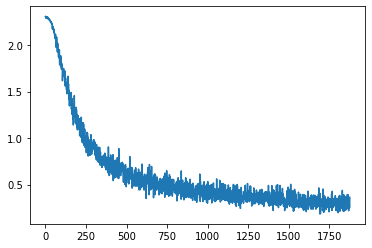

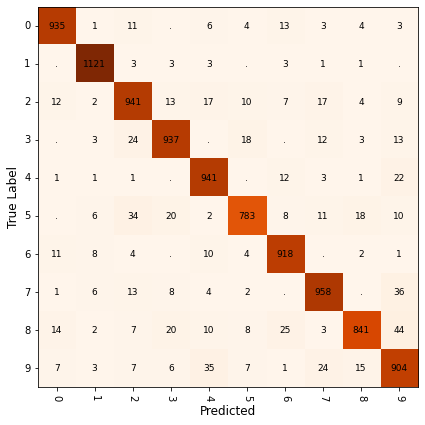

positive [ 980 1135 1032 1010  982  892  958 1028  974 1009]
negative [9020 8865 8968 8990 9018 9108 9042 8972 9026 8991]
--
tp [ 935 1121  941  937  941  783  918  958  841  904]
tpr [0.95408163 0.9876652  0.91182171 0.92772277 0.95824847 0.87780269
 0.95824635 0.93190661 0.86344969 0.89593657]
--
fp [ 46  32 104  70  87  53  69  74  48 138]
fpr [0.00509978 0.0036097  0.01159679 0.00778643 0.00964737 0.00581906
 0.00763106 0.00824788 0.00531797 0.01534868]
--
fn [ 45  14  91  73  41 109  40  70 133 105]
tn [8974 8833 8864 8920 8931 9055 8973 8898 8978 8853]
acc [0.9909 0.9954 0.9805 0.9857 0.9872 0.9838 0.9891 0.9856 0.9819 0.9757]


In [68]:
model = MNISTClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
losses = []
train_labels = []
train_preds = []
for e in range(2):
    print(e)
    for x, y in train_loader:
        opt.zero_grad()
        y = y.to(device)
        logits = model(x.to(device))
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
        predicted_labels = logits.argmax(1).cpu().detach().numpy()
        train_preds.append( predicted_labels )    
        train_labels.append(y)

plt.plot(losses)


print("Train metrics")
train_preds_  = np.concatenate(train_preds, axis=0)
train_labels_ = np.concatenate(train_labels, axis=0)
calculate_metrix(train_labels_, train_preds_)

test_labels = []
test_preds = []

with torch.no_grad():
    for x, y in test_loader:
        logits = model(x.to(device))
        predicted_labels = logits.argmax(1).cpu().detach().numpy()
        test_preds.append(predicted_labels)
        test_labels.append(y)

print("Test metrics")
test_preds_ = np.concatenate(test_preds, axis=0)
test_labels_ = np.concatenate(test_labels, axis=0)

print(accuracy_score(test_labels_, test_preds_))

generate_matplotlib_cm(confusion_matrix(test_labels_, test_preds_), name_dict)


calculate_metrix(test_labels_, test_preds_)


as we can see in metrics, making the model more complicated, also improves the accuracy 

## We can train model longer

0
1
2
3
4
Train metrics
positive [118460 134840 119160 122620 116840 108420 118360 125300 117020 118980]
negative [1081540 1065160 1080840 1077380 1083160 1091580 1081640 1074700 1082980
 1081020]
--
tp [106896 130625  97720 105473 102580  90845 106215 111914  98885  96621]
tpr [0.90238055 0.96874073 0.82007385 0.86016147 0.87795276 0.83789891
 0.89738932 0.8931684  0.84502649 0.81207766]
--
fp [15149  9162 18015 19602 12732 16485 11688 14555 17614 17224]
fpr [0.01400688 0.00860152 0.01666759 0.01819414 0.0117545  0.01510196
 0.01080581 0.01354331 0.01626438 0.0159331 ]
--
fn [11564  4215 21440 17147 14260 17575 12145 13386 18135 22359]
tn [1066391 1055998 1062825 1057778 1070428 1075095 1069952 1060145 1065366
 1063796]
acc [0.97773917 0.9888525  0.96712083 0.96937583 0.97750667 0.97161667
 0.98013917 0.97671583 0.97020917 0.96701417]
Test metrics
0.9566


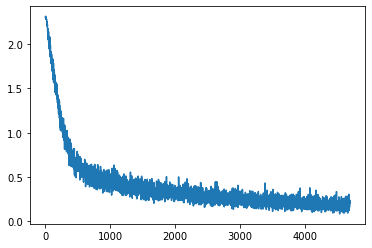

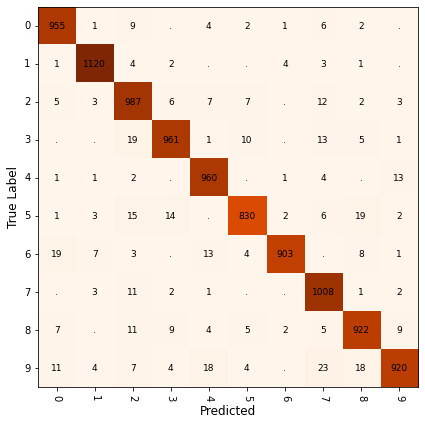

positive [ 980 1135 1032 1010  982  892  958 1028  974 1009]
negative [9020 8865 8968 8990 9018 9108 9042 8972 9026 8991]
--
tp [ 955 1120  987  961  960  830  903 1008  922  920]
tpr [0.9744898  0.98678414 0.95639535 0.95148515 0.97759674 0.93049327
 0.94258873 0.98054475 0.94661191 0.91179386]
--
fp [45 22 81 37 48 32 10 72 56 31]
fpr [0.00498891 0.00248167 0.00903211 0.00411568 0.00532269 0.00351339
 0.00110595 0.00802497 0.0062043  0.00344789]
--
fn [25 15 45 49 22 62 55 20 52 89]
tn [8975 8843 8887 8953 8970 9076 9032 8900 8970 8960]
acc [0.993  0.9963 0.9874 0.9914 0.993  0.9906 0.9935 0.9908 0.9892 0.988 ]


In [69]:
model = MNISTClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
losses = []
train_labels = []
train_preds = []
for e in range(5):
    print(e)
    for x, y in train_loader:
        opt.zero_grad()
        y = y.to(device)
        logits = model(x.to(device))
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
        predicted_labels = logits.argmax(1).cpu().detach().numpy()
        train_preds.append( predicted_labels )    
        train_labels.append(y)

plt.plot(losses)


print("Train metrics")
train_preds_  = np.concatenate(train_preds, axis=0)
train_labels_ = np.concatenate(train_labels, axis=0)
calculate_metrix(train_labels_, train_preds_)

test_labels = []
test_preds = []

with torch.no_grad():
    for x, y in test_loader:
        logits = model(x.to(device))
        predicted_labels = logits.argmax(1).cpu().detach().numpy()
        test_preds.append(predicted_labels)
        test_labels.append(y)

print("Test metrics")
test_preds_ = np.concatenate(test_preds, axis=0)
test_labels_ = np.concatenate(test_labels, axis=0)

print(accuracy_score(test_labels_, test_preds_))

generate_matplotlib_cm(confusion_matrix(test_labels_, test_preds_), name_dict)


calculate_metrix(test_labels_, test_preds_)